> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Prediction and Evaluation

In [4]:
import os

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [5]:
bundle_uri = 's3://azavea-research-public-data/raster-vision/examples/model-zoo-0.21/spacenet-vegas-buildings-ss/train/model-bundle.zip'

In [6]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(bundle_uri, training=False)

c:\Users\CalvinPuah-Pernix\anaconda3\envs\rastervision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-07 14:25:07:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle s3://azavea-research-public-data/raster-vision/examples/model-zoo-0.21/spacenet-vegas-buildings-ss/train/model-bundle.zip.
2024-03-07 14:25:07:rastervision.pipeline.file_system.utils: INFO - Using cached file C:\Users\CALVIN~1\AppData\Local\Temp\cache\s3\azavea-research-public-data\raster-vision/examples/model-zoo-0.21/spacenet-vegas-buildings-ss/train/model-bundle.zip.
2024-03-07 14:25:07:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to C:\Users\CALVIN~1\AppData\Local\Temp\tmpe2vumm0p\model-bundle
2024-03-07 14:25:11:rastervision.pytorch_learner.learner: INFO - Local output dir: C:\Users\CALVIN~1\Ap

## Get scene to predict

In [7]:
#scene_id = 5631
#image_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img{scene_id}.tif'
#label_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img{scene_id}.geojson'

In [19]:
scene_id = 205
image_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img{scene_id}.tif'
label_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img{scene_id}.geojson'

In [20]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['building', 'background'], 
    colors=['orange', 'black'])
class_config.ensure_null_class()

In [21]:
from rastervision.core.data import ClassConfig
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset

import albumentations as A

ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    size=325,
    stride=325,
    transform=A.Resize(325, 325))

2024-03-07 14:28:11:rastervision.pipeline.file_system.utils: INFO - Downloading s3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img205.tif to C:\Users\CALVIN~1\AppData\Local\Temp\cache\s3\spacenet-dataset\spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img205.tif...


Downloading: 100%|██████████| 2.42M/2.42M [00:07<00:00, 328kB/s]


In [22]:
from rastervision.core.data import SemanticSegmentationLabels

predictions = learner.predict_dataset(
    ds,
    raw_out=True,
    numpy_out=True,
    predict_kw=dict(out_shape=(325, 325)),
    progress_bar=True,
     dataloader_kw=dict(num_workers=0)
    )

pred_labels = SemanticSegmentationLabels.from_predictions(
    ds.windows,
    predictions,
    smooth=True,
    extent=ds.scene.extent,
    num_classes=len(class_config))

Predicting: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


## Visualize predictions

In [23]:
scores = pred_labels.get_score_arr(pred_labels.extent)

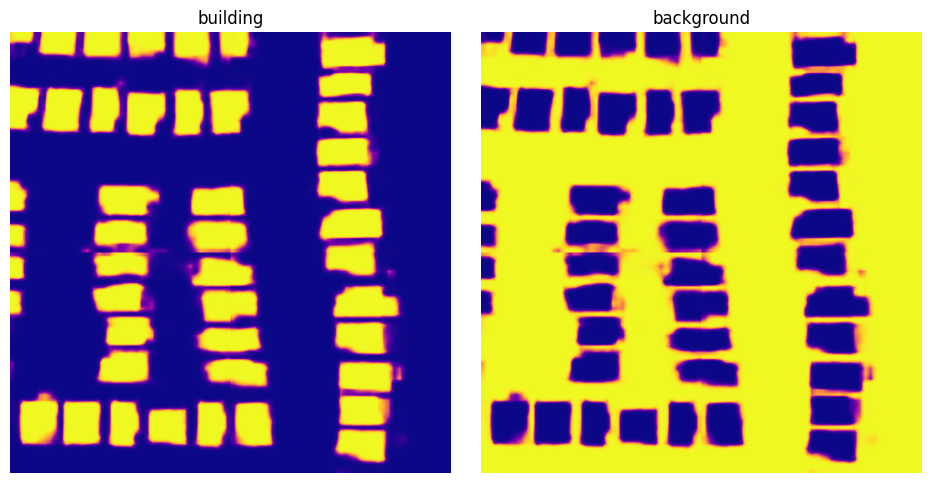

In [24]:
from matplotlib import pyplot as plt

scores_building = scores[0]
scores_background = scores[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(w_pad=-2)
ax1.imshow(scores_building, cmap='plasma')
ax1.axis('off')
ax1.set_title('building')
ax2.imshow(scores_background, cmap='plasma')
ax2.axis('off')
ax2.set_title('background')
plt.show()

In [25]:
pred_labels.save(
    uri=f'./spacenet-vegas-buildings-ss/predict/{scene_id}',
    crs_transformer=ds.scene.raster_source.crs_transformer,
    class_config=class_config)

Saving pixel scores: 100%|██████████| 2/2 [00:00<00:00, 77.36it/s]


## Evaluate predictions

In [26]:
from rastervision.core.data.utils import make_ss_scene

scene = make_ss_scene(
    class_config=class_config,
    image_uri=image_uri,
    label_vector_uri=label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    label_raster_source_kw=dict(
        background_class_id=class_config.get_class_id('background')),
    image_raster_source_kw=dict(allow_streaming=True))

gt_labels = scene.label_source.get_labels()

2024-03-07 14:28:31:rastervision.pipeline.file_system.utils: INFO - Downloading s3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img205.geojson to C:\Users\CALVIN~1\AppData\Local\Temp\cache\s3\spacenet-dataset\spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img205.geojson...
2024-03-07 14:28:33:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in s3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img205.geojson and assuming EPSG:4326 instead.


In [27]:
from rastervision.core.evaluation import SemanticSegmentationEvaluator

evaluator = SemanticSegmentationEvaluator(class_config)

evaluation = evaluator.evaluate_predictions(
    ground_truth=gt_labels, predictions=pred_labels)

Evaluation for the building class:

In [28]:
evaluation.class_to_eval_item[0]

{'class_id': 0,
 'class_name': 'building',
 'conf_mat': [[294412.0, 7976.0], [7211.0, 112901.0]],
 'conf_mat_dict': {'FN': 7211.0, 'FP': 7976.0, 'TN': 294412.0, 'TP': 112901.0},
 'conf_mat_frac': [[0.6968331360946746, 0.01887810650887574],
                   [0.017067455621301776, 0.2672213017751479]],
 'conf_mat_frac_dict': {'FN': 0.017067455621301776,
                        'FP': 0.01887810650887574,
                        'TN': 0.6968331360946746,
                        'TP': 0.2672213017751479},
 'count_error': 765.0,
 'gt_count': 120112.0,
 'metrics': {'f1': 0.9369805260821032,
             'precision': 0.934015569545902,
             'recall': 0.9399643665911815,
             'sensitivity': 0.9399643665911815,
             'specificity': 0.973623291929574},
 'pred_count': 120877.0,
 'relative_frequency': 0.2842887573964497}

Evaluation for the background class:

In [29]:
evaluation.class_to_eval_item[1]

{'class_id': 1,
 'class_name': 'background',
 'conf_mat': [[112901.0, 7211.0], [7976.0, 294412.0]],
 'conf_mat_dict': {'FN': 7976.0, 'FP': 7211.0, 'TN': 112901.0, 'TP': 294412.0},
 'conf_mat_frac': [[0.2672213017751479, 0.017067455621301776],
                   [0.01887810650887574, 0.6968331360946746]],
 'conf_mat_frac_dict': {'FN': 0.01887810650887574,
                        'FP': 0.017067455621301776,
                        'TN': 0.2672213017751479,
                        'TP': 0.6968331360946746},
 'count_error': 765.0,
 'gt_count': 302388.0,
 'metrics': {'f1': 0.9748564181778147,
             'precision': 0.9760926719779327,
             'recall': 0.973623291929574,
             'sensitivity': 0.973623291929574,
             'specificity': 0.9399643665911815},
 'pred_count': 301623.0,
 'relative_frequency': 0.7157112426035503}

### Save evaluation

In [30]:
evaluation.save(f'eval-{scene_id}.json')